In [2]:
import numpy as np

#Load XYZ file
xyz_file = r"./salt_3UC.xyz"
species = np.loadtxt(xyz_file, skiprows = 2, usecols = (0,), dtype = str)
posns = np.loadtxt(xyz_file, skiprows = 2, usecols = (1,2,3))
N_atoms = len(species)
print(N_atoms)
species_map = {"Na" : 1, "Cl" : 2}
charge_map = {"Na" : 1, "Cl" : -1}

216


In [650]:
# 2D direct summation 

def directSum_2D(r, q, a, n=10):
    U = 0 
    charges = len(q)
    vecs = np.arange(-n, n+1)
    for idx in range(charges):
        for idx2 in range(charges):
            for i in vecs:
                for j in vecs:
                    if i == 0 and j == 0 and idx == idx2:
                        continue
                    dist = np.linalg.norm(r[idx] - r[idx2] + i*a[0] + j*a[1])
                    if dist == 0:
                        continue 
                    U += q[idx]*q[idx2]/dist
    return U/2

def directSum_3D(r, q, a, n=2):
    U = 0 
    charges = len(q)
    vecs = np.arange(-n, n+1)
    for idx in range(charges):
        for idx2 in range(charges):
            for i in vecs:
                for j in vecs:
                    for k in vecs:
                        if i == 0 and j == 0 and k == 0 and idx == idx2:
                            continue
                        dist = np.linalg.norm(r[idx] - r[idx2] + i*a[0] + j*a[1] + k*a[2])
                        if dist == 0:
                            continue
                        U += q[idx]*q[idx2]/dist
    return U/2
                    


# M2 
def M(u):
    return np.where((u >= 0) & (u <= 2), 1 - np.abs(1 - u), 0)


# 4th order B-spline
def BSpline(u):
    M_not = M(u)
    M_minus = M(u-1)
    M_minus_minus = M(u-2)
    return (u/3) * ((u/2)*M_not + ((3-u)/2)*M_minus) + ((4-u)/3)*(((u-1)/2)*M_minus + ((4-u)/2)*M_minus_minus)

def b(m, K, l=4):
    # Complex number i 
    i = complex(0,1)
    k = np.arange(0,l-1)
    return np.exp(2*np.pi*i*(m/K)*(l-1))/np.sum(BSpline(k+1)*np.exp(2*np.pi*i*(m/K)*(k)))


def Q(m, K, q, u, l=4, n=5):
    # Complex number i 
    i = complex(0,1)
    charges = len(q)
    outerSum = 0 
    integers = np.arange(0, n+1)

    for idx in range(charges):
        innerSum = 0
        for n1 in integers:
            for n2 in integers:
                for n3 in integers:
                    innerSum += BSpline(u[idx, 0] - m[0] - n1*K[0])*BSpline(u[idx, 1] - m[1] - n2*K[1])*BSpline(u[idx, 2] - m[2] - n3*K[2])
        outerSum += q[idx]*innerSum
    return outerSum


def S(m, K, q, u, l=4, n=5):
    # Complex number i 
    return b(m[0], K[0])*b(m[1], K[1])*b(m[2], K[2])*np.fft.fft([Q(m, K, q, u, l, n)])
        

        
def Q_2D(m, K, q, u, l=4, n=5):
    charges = len(q)
    outerSum = 0 
    integers = np.arange(0, n+1)

    for idx in range(charges):
        innerSum = 0
        for n1 in integers:
            for n2 in integers:
                    innerSum += BSpline(u[idx, 0] - m[0] - n1*K[0])*BSpline(u[idx, 1] - m[1] - n2*K[1])
        outerSum += q[idx]*innerSum
    return outerSum


def S_2D(m, K, q, u, l=4, n=5):
    # Complex number i 
    return b(m[0], K[0])*b(m[1], K[1])*np.fft.fft([Q_2D(m, K, q, u, l, n)])


def Q_mat_2D(K, q, u, l=4, n=5):
    K1 = np.arange(0, K[0])
    K2 = np.arange(0, K[1])
    Q_mat = np.zeros((len(K1), len(K2)))
    for k1 in K1:
        for k2 in K2:
            for u_image in u:
                Q_mat[k2, k1] += Q_2D([k1, k2], K, q, u_image, n) 

    shift = int(np.ceil(l/2))
    Q_mat = np.roll(Q_mat, shift, axis=0) # Up shifts 
    Q_mat = np.roll(Q_mat, shift, axis=1) # Right shifts
    return Q_mat


def Q_mat_2D_mod(K, q, u, l=4, n=5, image=0):
    #K1 = np.arange(0, (2*image+1)*K[0])
    #K2 = np.arange(0, (2*image+1)*K[0])

    Q_mat = np.zeros((K[0], K[1])) # Only want matrix of first image 
    images = np.arange(-image, image+1)

    for k1 in range(K[0]):
        for k2 in range(K[1]):
            for u_image in u:
                Q_mat[k2, k1] += Q_2D([k1, k2], K, q, u_image, n) 

    shift = int(np.ceil(l/2))
    Q_mat = np.roll(Q_mat, shift, axis=0) # Up shifts 
    Q_mat = np.roll(Q_mat, shift, axis=1) # Right shifts
    return Q_mat

    






In [630]:
images = np.arange(0, 3)
shifts = [[im1, im2] for im1, im2 in zip(images,images)]
shifts

[[0, 0], [1, 1], [2, 2]]

In [4]:
# Get charges and corrdinates 
q = np.zeros(N_atoms)
r = np.zeros((N_atoms, 3))
for i in range(N_atoms):
    q[i] = charge_map[species[i]]
    r[i] = posns[i]

In [414]:
q_2D = charges_2D
r_2D = posns_2D

In [554]:
# Define unit vectors  
a1 = np.array([16.8, 0, 0])
a2 = np.array([0, 16.8, 0])
a3 = np.array([0, 0, 16.8])

# Define recirpocal vectors
a1_star = np.array([1/(3*14.05), 0, 0])
a2_star = np.array([0, 1/(3*14.05), 0])
a3_star =  np.array([0, 0, 1/(3*14.05)])

# Make order for the m vectors 
order = 2 
m = np.arange(-order, order+1)


In [248]:
#-9817.1143987478189956

# Convert from 
epsilon = 8.854187817*10**(-12) # C^2/(J*m)

U = -67.4159430404001 * (1.60217653*10**(-19))**2 # C^2 
U *= 10**(10) # Angstrom -> meter

U /= (4*np.pi*epsilon) # J 
# Convert joules to eV 
U /= (1.60217653*10**(-19)) # eV
# Convert to kcal/mol 
U *= 23.0605 # kcal/mol


-22386.340485484325

In [435]:
conversionFactor = 332.06300284294696 # C^2/Angstrom -> kcal/mol


In [11]:
# Steps of PME algorithm
'''
1. Define grid and perform B-spine interpolation
2. ...
'''

0.0

In [544]:
# 1. Define grid and perform B-spine interpolation
K1, K2, K3 = 21, 21, 21 # Split the grid into K1 x K2 x K3 cells
K = [K1, K2, K3]
a_star = [a1_star, a2_star, a3_star]

# Define fractional coordinates for each particle 
u = np.zeros((N_atoms, 3))
for i in range(N_atoms):
    for j in range(3):
        u[i, j] = K[j] * a_star[j].dot(r[i])


In [585]:
# 1. Define grid and perform B-spine interpolation
K1, K2, K3 = 21, 21, 21 # Split the grid into K1 x K2 x K3 cells
# We need to incorporate the periodic boundary conditions
K1, K2 = 63, 63
K = [K1, K2]
a_star_2D = [a1_star, a2_star]
a_star = [a1_star, a2_star, a3_star]


# Define fractional coordinates for each particle 
# u_2D = np.zeros((10, 2))
# for i in range(10):
#     for j in range(2):
#         u_2D[i][j] = K[j] * a_star[j][:2].dot(r_2D[i])

In [599]:
r_2D_top = r_2D + np.array([14.05, 28.1])
r_2D_bottom = r_2D + np.array([14.05, 0])
r_2D_right = r_2D + np.array([28.1, 14.05])
r_2D_left = r_2D + np.array([0, 14.05])
r_2D_topleft = r_2D + np.array([0, 28.1])
r_2D_topright = r_2D + np.array([28.1, 28.1])
r_2D_bottomleft = r_2D + np.array([0, 0])
r_2D_bottomright = r_2D + np.array([28.1, 0])
r_2D_shifted = r_2D + np.array([14.05, 14.05])

u_2D = np.zeros((10, 2))
u_2D_top = np.zeros((10, 2))
u_2D_bottom = np.zeros((10, 2))
u_2D_right = np.zeros((10, 2))
u_2D_left = np.zeros((10, 2))
u_2D_topleft = np.zeros((10, 2))
u_2D_topright = np.zeros((10, 2))
u_2D_bottomleft = np.zeros((10, 2))
u_2D_bottomright = np.zeros((10, 2))

for i in range(10):
    for j in range(2):
        u_2D[i][j] = K[j] * a_star[j][:2].dot(r_2D_shifted[i])
        u_2D_top[i][j] = K[j] * a_star[j][:2].dot(r_2D_top[i])
        u_2D_bottom[i][j] = K[j] * a_star[j][:2].dot(r_2D_bottom[i])
        u_2D_right[i][j] = K[j] * a_star[j][:2].dot(r_2D_right[i])
        u_2D_left[i][j] = K[j] * a_star[j][:2].dot(r_2D_left[i])
        u_2D_topleft[i][j] = K[j] * a_star[j][:2].dot(r_2D_topleft[i])
        u_2D_topright[i][j] = K[j] * a_star[j][:2].dot(r_2D_topright[i])
        u_2D_bottomleft[i][j] = K[j] * a_star[j][:2].dot(r_2D_bottomleft[i])
        u_2D_bottomright[i][j] = K[j] * a_star[j][:2].dot(r_2D_bottomright[i])
        

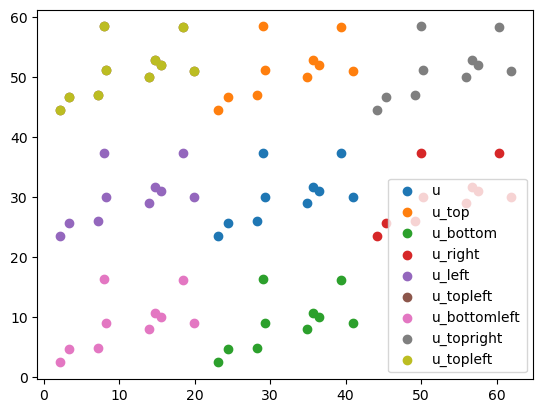

In [600]:
import matplotlib.pyplot as plt
plt.scatter(u_2D[:, 0], u_2D[:,1], label='u')
plt.scatter(u_2D_top[:,0], u_2D_top[:,1], label='u_top')
plt.scatter(u_2D_bottom[:,0], u_2D_bottom[:,1], label='u_bottom')
plt.scatter(u_2D_right[:,0], u_2D_right[:,1], label='u_right')
plt.scatter(u_2D_left[:,0], u_2D_left[:,1], label='u_left')

plt.scatter(u_2D_topleft[:,0], u_2D_topleft[:,1], label='u_topleft')
plt.scatter(u_2D_bottomleft[:,0], u_2D_bottomleft[:,1], label='u_bottomleft')
plt.scatter(u_2D_topright[:,0], u_2D_topright[:,1], label='u_topright')
plt.scatter(u_2D_topleft[:,0], u_2D_topleft[:,1], label='u_topleft')

plt.legend()
plt.show()




In [620]:
u_images = [u_2D, u_2D_top, u_2D_bottom, u_2D_right, u_2D_left, u_2D_topleft, u_2D_topright, u_2D_bottomleft, u_2D_bottomright]


In [621]:
Q_mat = Q_mat_2D(K, q_2D, u_images, n=2)


In [624]:
Q_mat_simple = Q_mat_2D(K, q_2D, [u_2D], n=2)


In [651]:
Q_mat_mod = Q_mat_2D_mod([63,63], q_2D, u_images, n=2, image=1)

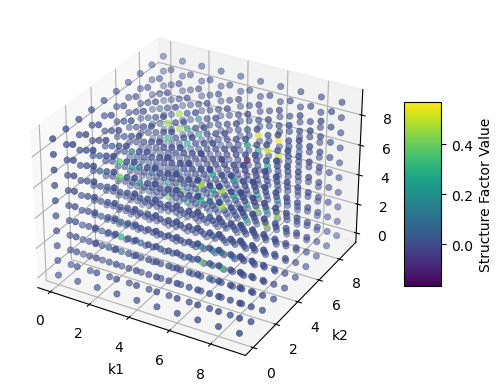

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming structureFactor is your 10x10x10 tensor
# Example: structureFactor = np.random.rand(10, 10, 10)

# Create a 10x10x10 grid
k1, k2, k3 = np.meshgrid(np.arange(10), np.arange(10), np.arange(10))

# Reshape the grid and structureFactor for plotting
k1 = k1.flatten()
k2 = k2.flatten()
k3 = k3.flatten()
structureFactor_flattened = structureFactor.flatten()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(k1, k2, k3, c=structureFactor_flattened, cmap='viridis', linewidth=0.5)

# Set labels
ax.set_xlabel('k1')
ax.set_ylabel('k2')
ax.set_zlabel('k3')


cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Structure Factor Value')

# Show plot
plt.show()


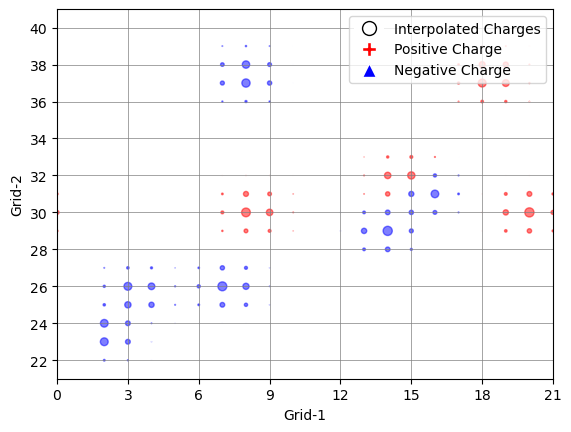

In [644]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Selecting a 2D slice of the structureFactor
# Create a 10x10 grid
k1, k2 = np.meshgrid(np.arange(63), np.arange(63))

# Flatten the grid for plotting
k1_flattened = k1.flatten()
k2_flattened = k2.flatten()
Q_mat_2D_flattened = Q_mat.flatten()

# Define colors based on sign: e.g., red for positive, blue for negative
colors = np.where(Q_mat_2D_flattened > 0, 'red', 'blue')

# Define sizes based on the absolute value of the structure factor
size_scale = 100
sizes = np.abs(Q_mat_2D_flattened) * size_scale

# Plotting
fig, ax = plt.subplots()

# Scatter plot with sizes based on magnitude and colors based on sign

sc = ax.scatter(k1_flattened, k2_flattened, s=sizes, color=colors, alpha = 0.5)

positive_indices = np.where(q_2D > 0)
negative_indices = np.where(q_2D < 0)
#plt.scatter(u_2D[positive_indices, 0], u_2D[positive_indices, 1], color='red',  marker='P',  edgecolors='black')
#plt.scatter(u_2D[negative_indices, 0], u_2D[negative_indices, 1], color='blue', marker='^',  edgecolors='black')
# Set labels
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Interpolated Charges', markerfacecolor='white', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='P', color='w', label='Positive Charge', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Negative Charge', markerfacecolor='blue', markersize=10)
    # Add more markers as needed
]

ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)

plt.xlabel('Grid-1')
plt.ylabel('Grid-2')

plt.xlim(0, 21)
plt.ylim(21, 41)
ax.legend(handles=legend_elements, loc='upper right')

# Show plot
plt.show()

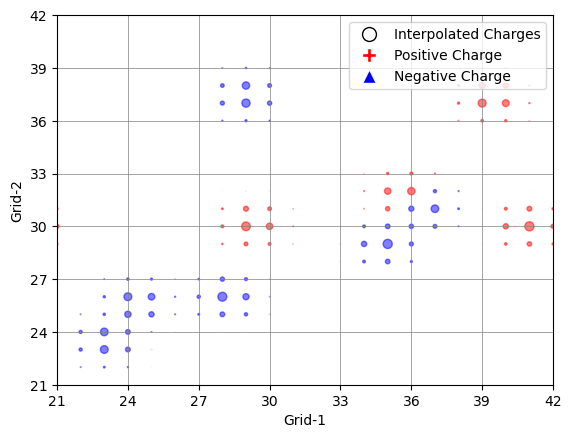

In [656]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Selecting a 2D slice of the structureFactor
# Create a 10x10 grid
k1, k2 = np.meshgrid(np.arange(63), np.arange(63))

# Flatten the grid for plotting
k1_flattened = k1.flatten()
k2_flattened = k2.flatten()
Q_mat_2D_flattened = Q_mat_mod.flatten()

# Define colors based on sign: e.g., red for positive, blue for negative
colors = np.where(Q_mat_2D_flattened > 0, 'red', 'blue')

# Define sizes based on the absolute value of the structure factor
size_scale = 100
sizes = np.abs(Q_mat_2D_flattened) * size_scale

# Plotting
fig, ax = plt.subplots()

# Scatter plot with sizes based on magnitude and colors based on sign

sc = ax.scatter(k1_flattened, k2_flattened, s=sizes, color=colors, alpha = 0.5)

positive_indices = np.where(q_2D > 0)
negative_indices = np.where(q_2D < 0)
# plt.scatter(u_2D[positive_indices, 0], u_2D[positive_indices, 1], color='red',  marker='P',  edgecolors='black')
# plt.scatter(u_2D[negative_indices, 0], u_2D[negative_indices, 1], color='blue', marker='^',  edgecolors='black')
# Set labels
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Interpolated Charges', markerfacecolor='white', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='P', color='w', label='Positive Charge', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Negative Charge', markerfacecolor='blue', markersize=10)
    # Add more markers as needed
]

ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)

plt.xlabel('Grid-1')
plt.ylabel('Grid-2')

plt.xlim(21,42)
plt.ylim(21, 42)

ax.legend(handles=legend_elements, loc='upper right')

# Show plot
plt.show()